### Notes
#### Useful links
- blog about data sources: https://towardsdatascience.com/a-short-review-of-covid-19-data-sources-ba7f7aa1c342
- GitHub repo of John Hopkinns CSSE: https://github.com/CSSEGISandData/COVID-19
#### Learning pandas
- useful link to learn pandas: https://www.learndatasci.com/tutorials/python-pandas-tutorial-complete-introduction-for-beginners/
- pandas is derived from the term "panel data", an econometrics term for data sets that include observations over multiple time periods for the same individuals
- pandas is built on top of the NumPy package, meaning a lot of the structure of NumPy is used or replicated in Pandas. Data in pandas is often used to feed statistical analysis in SciPy, plotting functions from Matplotlib, and machine learning algorithms in Scikit-learn
- a Series is essentially a column, and a DataFrame is a multi-dimensional table made up of a collection of Series
- two primary components of pandas are: series and dataframes
- handling missing data values: most commonly you'll see Python's 'None' or NumPy's 'np.nan', each of which are handled differently in some situations
- two options to deal with missing data values:get rid of them or replace them (called imputation)

### Imported modules

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### Reading COVID19 infection spread data from JHCSSE

In [2]:
#reading data from GitHub
jhCsseURL='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
frm=pd.read_csv(jhCsseURL,index_col=1)
frm=frm.transpose() #switching to have countries in columns

#dataset information
frm.shape
frm.head()
frm.tail()
frm.info()

'''
#data cleaning
##remove duplicates
frm.shape
tempfrm=frm
tempfrm.drop_duplicates(inplace=True) # OR tempfrm=tempfrm.drop_duplicates()
#tempfrm.drop_duplicates(inplace=True,keep='first') #remove all duplicates except first (DEFAULT)
#tempfrm.drop_duplicates(inplace=True,keep='last') #remove all duplicates except last
#tempfrm.drop_duplicates(inplace=True,keep=False) #remove all duplicates
tempfrm.shape
##cleaning columns
frm.columns
frm.rename(columns={'Province/State':'Area'},inplace=True) #renaming to simpler names
frm.columns
frm.columns=[col.lower() for col in frm.columns] #lowercase for all colnames
frm.columns
##dealing missing data values
frm.isnull() #return true/false for each cell
frm.isnull().sum() #counts the total number of true
#frm.dropna(inplace=True)#will delete any row with at least a single null value (only use if very few na)
#frm.dropna(axis=1,inplace=True)#will delete any column with at least a single null value (only use if very few na)
area=frm['area']
area.head()
area.fillna('Unknown',inplace=True) #imputing null values with 'missing'
frm.isnull().sum()
frm.head()
'''

#data statistics
#distibution
#frm.describe()
#frm['India'].describe() #can be performed on categorical data also
#frm['India'].value_counts() #gives frequency of all the categories
#correlation
#frm.corr() #generates correlation matrix

frm.head()
frm['India']
frm['China']
frm['Italy']
series_Italy=frm['Italy']
series_Italy.shape
#np.asarray(series_Italy)[40]
series_Italy.keys()[32]
series_Italy[series_Italy.keys()[32]]

<class 'pandas.core.frame.DataFrame'>
Index: 102 entries, Province/State to 4/29/20
Columns: 264 entries, Afghanistan to Yemen
dtypes: object(264)
memory usage: 211.2+ KB


0

### Picking a country and visualizing the data

([<matplotlib.axis.XTick at 0x2d364bc9400>,
 <a list of 10 Text xticklabel objects>)

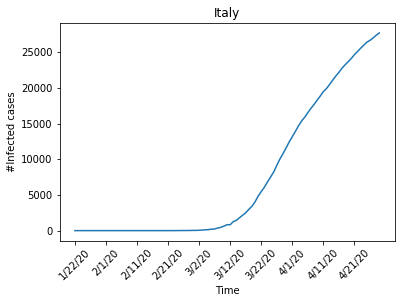

In [6]:
##set country
Country_Name='Italy'
Data_Series=frm[Country_Name]
Time_Points=[]
Infected_Cases=[]
for i in Data_Series.keys()[3:]:
    [m,d,y]=i.split('/')
    y=2000+int(y)
    m=int(m)
    d=int(d)
    #print(y,m,d)
    Day_Count=dt.datetime(y,m,d).strftime('%j')
    Day_Count=int(Day_Count)
    Time_Points.append(Day_Count)
    Infected_Cases.append(Data_Series[i])
Time_Points=[i-Time_Points[0] for i in Time_Points]
len(Time_Points)
len(Infected_Cases)
x_Ticks=list(Data_Series.keys()[3:])
Display_Points=np.arange(min(Time_Points),max(Time_Points)+1,10)
Display_Ticks=[x_Ticks[i] for i in Display_Points]
plt.plot(Time_Points,Infected_Cases)
plt.xlabel('Time')
plt.ylabel('#Infected cases')
plt.title(Country_Name)
plt.xticks(Display_Points,Display_Ticks,rotation=45)

### SIRDH model

#### Parameters

In [ ]:
#parameter definitions

##k[0]->mixing rate of population
##k[1]->infectious period
##k[2]->re-infection period
##k[3]->death period
##k[4]->mixing rate of H
##k[5]->infectious period with treatment
##k[6]->PPE treatment

###Case1: Italy (www.worldometers.info, international.commonwealthfund.org, www.icn.ch, www.ecdc.europa.eu, https://patient.info/news-and-features/coronavirus-how-quickly-do-covid-19-symptoms-develop-and-how-long-do-they-last)
#data from February 20th till April 25th
numDays=65
Popul=60477673
numInf=192990
numDead=25969
numRec=60498
numSus=Popul-numInf
HCfract=0.01 #10 healthcare workers per 1000 population 
numHC=HCfract*Popul
HinfRate=0.09 #9% of infected cases are healthcare workers
numHinf=HinfRate*numInf
ReqPPE=45/10 #number of PPE required per H per I per day

#parameters
k=np.zeros(7)
k[0]=0.275 #27.5% of population are mixing
k[1]=1/14 #time from infection to natural recovery
k[2]=1/30 #re-infection rate is very rare
k[3]=1/21
k[4]=1 #healthcare workers are in contact with patients 100%
k[5]=1/10
k[6]= 0.7 #assume 70% of required PPE is available 
N=Popul*20 #assuming 20% of population are vulnerable

#Initial conditions
ic=np.zeros(4)
ic[0]= 4 #infected
ic[1]= 0 #recovered
ic[2]= 0 #dead
ic[3]= numHC*70 #assuming 70% of healthcare workers are available for SARS-CoV2

k

#### Model definition

In [ ]:
#model definition
def modSEIR(y,t,N,k):
    #assignments
    S=N-sum(y[0:3])
    dy=[0]*4

    #reaction rates
    v0=k[0]*(S/N)*(y[0]/N)
    v1=k[1]*(y[0]/N)
    v2=k[2]*(y[1]/N)
    v3=k[3]*(y[0]/N)
    v4=(k[4]-k[6])*(y[3]/N)*(y[0]/N)
#    v4=(k[4]/k[6])*(y[3]/N)*(y[0]/N)
#    v5=(k[5]*k[6])*(y[3]/N)
    v5=(k[5])*(y[3]/N)*(y[0]/N)

    #ODEs
    dy[0]=N*(v0+v4-v1-v3) #I
    dy[1]=N*(v1+v5-v2) #R
    dy[2]=N*(v3) #D
    dy[3]=N*(-v4) #H

    return dy

##timeline
tmax=1*365 #days
tvec=np.arange(0,tmax,0.1)

##test
#k[0]=k[0]*10

##solving equations
soln=odeint(modSEIR,ic,tvec,args=(N,k))
##plotting solution
plt.figure(figsize=(13,5))
plt.subplot(1,3,1)
plt.plot(tvec,soln)
varTC=[i[0] for i in soln]
#plt.plot(tvec,varTC)
legend_labels = ("Infected","Recovered","Dead","Healthcare")
plt.xlabel("Time (days)")
plt.title("Italy COVID19 Profile")
plt.ylabel("Number of Cases")
plt.legend(legend_labels)
#plt.ylim([0,1000000])
print("# of infected difference (actual-model): "+str(int(numInf-[i[0] for i in soln][-1])))
print("# of recovered difference (actual-model): "+str(int(numRec-[i[1] for i in soln][-1])))
print("# of dead difference (actual-model): "+str(int(numDead-[i[2] for i in soln][-1])))

#### Parameter estimation

In [ ]:
# cleaned up a bit to get my head around it - thanks for sharing 
import pylab as pp
import numpy as np
from scipy import integrate, optimize

class Fit_Parameters():
    def __init__(self):
        self.X = np.linspace(0,9,10)
        self.y = np.array([0.000,0.416,0.489,0.595,0.506,0.493,0.458,0.394,0.335,0.309])
        self.y0 = [1,0,0] # inital conditions ODEs
    def ode(self, y, X, p):
        return (-p[0]*y[0],
                 p[0]*y[0]-p[1]*y[1],
                           p[1]*y[1])
    def model(self, X, p):
        return integrate.odeint(self.ode, self.y0, X, args=(p,))
    def f_resid(self, p):
        return self.y - self.model(self.X, p)[:,1]
    def optim(self, p_quess):
        return optimize.leastsq(self.f_resid, p_guess) # fit params

po = Fit_Parameters(); p_guess = [0.2, 0.3] 
c, kvg = po.optim(p_guess)

# --- show ---
print("parameter values are ", c, kvg)
x = np.linspace(min(po.X), max(po.X), 2000)
pp.plot(po.X, po.y,'.r',x, po.model(x, c)[:,1],'-b')
pp.xlabel('X',{"fontsize":16}); pp.ylabel("y",{"fontsize":16}); pp.legend(('data','fit'),loc=0); pp.show()